In [1]:
import pandas as pd
import numpy as np

In [2]:
hap_f_path = 'examples/CCDG_14151_B01_GRM_WGS_2020-08-05_chr19.filtered.shapeit2-duohmm-phased.2504.43-47Mb.ALL.maf01.haps.gz'
sample_f_path = 'examples/CCDG_14151_B01_GRM_WGS_2020-08-05_chr19.filtered.shapeit2-duohmm-phased.2504.43-47Mb.ALL.maf01.sample.gz'

In [3]:
total_numSNPs = 26246
examined_numSNPs = 5

In [4]:
import random
start_row = random.randint(0,total_numSNPs-examined_numSNPs)

In [5]:
import pickle

In [6]:
df = pd.read_csv(hap_f_path,header=None,sep=' ',skiprows=start_row,nrows=examined_numSNPs)

In [7]:
# make sure sort by position
df = df.sort_values(by=2)

In [8]:
with open(f'training_data_{examined_numSNPs}.pkl','wb') as f:
    pickle.dump((df,start_row,examined_numSNPs),f)

In [9]:
df

,0,1,2,3,4,5,6,7,8,9,...,5003,5004,5005,5006,5007,5008,5009,5010,5011,5012
0,19,19:45783456:A:C,45783456,C,A,1,0,1,1,0,...,1,1,1,1,1,0,1,1,0,0
1,19,19:45783942:C:G,45783942,G,C,1,0,1,1,0,...,0,0,1,1,0,0,1,1,0,0
2,19,19:45783955:T:C,45783955,C,T,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,19,19:45785148:G:A,45785148,A,G,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,19,19:45785448:A:T,45785448,T,A,0,0,1,1,0,...,0,0,0,1,0,0,0,1,0,0


In [10]:
haps = df.loc[:,5:].values

In [11]:
haps.shape

(5, 5008)

In [12]:
genos = np.full(shape=(haps.shape[0],haps.shape[1]//2),fill_value=-1,dtype=int)
## create genotypes by combining each pair of haplotypes
for i in range(genos.shape[1]):
    genos[:,i] = haps[:,2*i] + haps[:,2*i+1]
genos = genos.T

In [13]:
from scipy.special import logsumexp
import time
from pathlib import Path
import pickle
class haplotypeHMM(object):
    '''
    hidden_states -> mosaic state (X,Y), indicating states of diploids from haplotypes X and Y
    transition -> transition prob for mosaic state
    emission -> prob of genotype condition on mosaic state
    inital -> prob initial mosaic state
    
    '''
    def __init__(self, genotypes, diplotypes, possible_haplotypes,reverse_all_possible_haps_index,savedir='./checkpoints/',pseudocount=1e-100,seed=42):
        self.genotypes = list(set(genotypes))
        self.diplotypes = list(set(diplotypes))
        self.haplotypes = possible_haplotypes
        self.reverse_all_possible_haps_index = reverse_all_possible_haps_index
        self.seed = seed
        self.pseudocount = pseudocount
        self.transitions,self.emissions,self.initial = self.initialize_HMM_parameters_randomly(self.genotypes, self.diplotypes, self.seed)
        self.savedir = savedir
    def emit_prob(self, this_state, haplotype):
        return self.emissions[this_state][haplotype]
    
    def transition_prob(self, this_state, next_state):
        return self.transitions[this_state][next_state]
    
    def init_prob(self, this_state):
        return self.initial[this_state]

    def get_diplotypes(self):
        for state in self.diplotypes:
            yield state
    def get_genotypes(self):
        for genotype in self.genotypes:
            yield genotype
    def initialize_HMM_parameters_randomly(self, alphabet, states,seed):
        
        transitions = {}
        emissions = {}
        initial = {}
        np.random.seed(seed=seed)
        initial_rand = np.random.dirichlet(np.ones(len(self.diplotypes)))
        for i, state in enumerate(self.get_diplotypes()):
            transitions[state] = {}
            emissions[state] = {}
            initial[state] = initial_rand[i]
            emissions_rand = np.random.dirichlet(np.ones(len(self.genotypes)))
            transitions_rand = np.random.dirichlet(np.ones(len(self.diplotypes)))
            for j,geno in enumerate(self.get_genotypes()):
                emissions[state][geno] = emissions_rand[j]
            for j, next_state in enumerate(self.get_diplotypes()):
                transitions[state][next_state] = transitions_rand[j]
                
        return transitions,emissions,initial
#     def initialize_HMM_parameters_MACH(self, alphabet, states,seed):
#         theta = epsi = 0.01
#         H = len(self.haplotypes)
#         transitions = {}
#         emissions = {}
#         initial = {}
#         np.random.seed(seed=seed)
#         initial_rand = np.random.dirichlet(np.ones(len(self.diplotypes)))
#         for i, state in enumerate(self.get_diplotypes()):
#             transitions[state] = {}
#             emissions[state] = {}
#             initial[state] = initial_rand[i]
#             # update emission matrix
#             for j,geno in enumerate(self.get_genotypes()):
#                 if geno ==1:
#                     emissions[state][geno] = emissions_rand[j]
                
#             # update transition matrix
#             state_x, state_y = state
#             for j, next_state in enumerate(self.get_diplotypes()):
#                 next_state_x,next_state_y = next_state
#                 if (state_X != next_state_x) and (state_Y != next_state_y):
#                     transitions[state][next_state] =  theta**2/H**2
#                 elif (state_X != next_state_x) or (state_Y != next_state_y):
#                     transitions[state][next_state] =  (1-theta) * theta/H + theta**2/(H**2)
#                 else:
#                     transitions[state][next_state] =  (1-theta) ** 2+ 2*(1-theta)*theta/H + theta**2/(H**2)
#         return transitions,emissions,initial
    def logsumexp(self,lst):
        arr = np.array(lst)
#         log_arr =np.log(arr)
#         if np.any(arr<=0):
#             print(arr)
#             raise Exception()
        return logsumexp(arr)
    def forward(self, genotype):
        log_left_list = []
        log_left = {}
        for state in self.get_diplotypes():
            log_left[state] = np.log(self.init_prob(state)) + np.log(self.emit_prob(state, genotype[0]))
        log_left_list.append(log_left)
        for i in range(1, len(genotype)):
            log_left = {}
            for next_state in self.get_diplotypes(): 
                log_left[next_state] = 0
                temp_log_left =[]
                for this_state in self.get_diplotypes():
                    state_log_left = log_left_list[i-1][this_state] + np.log(self.transition_prob(this_state, next_state)) + np.log(self.emit_prob(next_state, genotype[i]))
                    assert state_log_left < 0
                    temp_log_left.append(state_log_left)
                log_left[next_state] =  self.logsumexp(temp_log_left)
            log_left_list.append(log_left)
#         posterior = 0
#         print(log_left_list)
        temp_log_left = []
        for state in self.get_diplotypes():
            assert log_left_list[-1][state] < 0
            temp_log_left.append(log_left_list[-1][state])
#             posterior += left_list[-1][state]
        posterior = self.logsumexp(temp_log_left)
        return posterior, log_left_list


    def backward(self, genotype):
        log_right_list = [] 
        log_right = {}
        for state in self.get_diplotypes():
            log_right[state] = 0
        log_right_list.append(log_right)

        for i in range(len(genotype)-1, 0, -1):
            log_right = {} 
            for state in self.get_diplotypes():
                temp_log_right = []
                for next_state in self.get_diplotypes():
                    state_log_right = log_right_list[0][next_state] + np.log(self.transition_prob(state, next_state)) + np.log(self.emit_prob(next_state, genotype[i]))
                    assert state_log_right < 0
                    temp_log_right.append(state_log_right)
                log_right[state] = self.logsumexp(temp_log_right)
            log_right_list.insert(0,log_right)
        
#         right_list = []
#         for log_right in log_right_list:
#             for this_state in self.get_diplotypes():
#                 log_right[this_state] = np.exp(log_right[this_state])
#             right_list.append(log_right)
#         posterior = 0
        temp_log_right = []
        for state in self.get_diplotypes():
            state_log_posterior = log_right_list[0][state] + np.log(self.init_prob(state)) + np.log(self.emit_prob(state, genotype[0]))
            assert state_log_posterior<0
            temp_log_right.append(state_log_posterior)
        posterior =  self.logsumexp(temp_log_right)

        return posterior, log_right_list
    
    def check_convergence(self,this_px,previous_px,eps):
        if np.linalg.norm(np.array(this_px) - np.array(previous_px))/np.linalg.norm(np.array(previous_px)) < eps:
            return True
        else:
            return False
    def fit(self,genotypes,max_it,eps,choice='Baum-Welch'):
        if choice == 'Baum-Welch':
            self.fit_Baum_Welch(genotypes,max_it,eps)
    
    def fit_Baum_Welch(self, genotypes, max_it,eps):
        # Train by Baum-Welch
        # Inititalization
        # store the previous complete likelihood of data
        previous_px = []
        for it in range(max_it):
            # intialize the temp parameters we use for this iteration
            transitions = {}
            emissions = {}
            initial = {}
            for k in self.get_diplotypes():
                transitions[k] = {}
                emissions[k] = {}
                initial[k] = []
                for l in self.get_diplotypes():
                    transitions[k][l] = []
                for m in self.get_genotypes():
                    emissions[k][m] = []
            # to store the complete likelihood of each sample
            this_px = []
            for genotype in genotypes:
                # forward and backward
                log_f_Px, log_f_matrix = self.forward(genotype)
                log_r_Px, log_r_matrix = self.backward(genotype)
                # store the complete likelihood of each sample. log_f_Px == log_r_Px with allowed marginal mismatch 
                this_px.append(log_f_Px)
                for k in self.get_diplotypes():
                    # Update transition matrix A
                    for l in self.get_diplotypes():
                        all_A = []
                        for i in range(len(genotype)-1):
                            all_A.append(log_f_matrix[i][k] + np.log(self.transition_prob(k,l)) + np.log(self.emit_prob(l, genotype[i+1])) + log_r_matrix[i+1][l])                            
                        transitions[k][l].append(-log_f_Px+ self.logsumexp(all_A))

                    # Update emission matrix E
                    for j, sigma in enumerate(self.get_genotypes()):
                        all_E = []
                        for i in range(len(genotype)):
                            if genotype[i] == sigma:
                                all_E.append(log_f_matrix[i][k] + log_r_matrix[i][k])
                        if len(all_E) != 0:
                            emissions[k][sigma].append(-log_f_Px +self.logsumexp(all_E))

                    # Update initial state matrix B
                    initial[k].append(-log_f_Px + log_f_matrix[0][k] + log_r_matrix[0][k])
            # Maximization
            for k in self.get_diplotypes():
                initial[k] = np.exp(self.logsumexp(initial[k]))
                for l in self.get_diplotypes():
                    transitions[k][l] = np.exp(self.logsumexp(transitions[k][l]))
                for m in self.get_genotypes():
                    emissions[k][m] = np.exp(self.logsumexp(emissions[k][m]))
                    
                    
                
            for k in self.get_diplotypes():
                sum_A = 0
                for l in self.get_diplotypes():
                    sum_A += transitions[k][l]
                for l in self.get_diplotypes():
                    transitions[k][l] = transitions[k][l]/sum_A


                sum_E = 0
                for j, sigma in enumerate(self.get_genotypes()):
                    sum_E += emissions[k][sigma]
                for j, sigma in enumerate(self.get_genotypes()):
                    emissions[k][sigma] = emissions[k][sigma]/sum_E

            sum_B = 0
            for k in self.get_diplotypes():
                sum_B += initial[k]
            for k in self.get_diplotypes():
                initial[k] = initial[k]/sum_B
            self.transitions = transitions
            self.emissions = emissions
            self.initial = initial
            self.save_checkpoint(self.savedir,it)
            # Check covergence
            if it > 0 and self.check_convergence(this_px,previous_px,eps):
                break
            previous_px = this_px
            with open(self.savedir+'/log.txt','a+') as fout:
                fout.write(f'Iteration:{it}:\n')
                fout.write(f'Average complete log likelihoods:{it}:\n')
                fout.write(str(np.mean(this_px))+'\n')
            print(f'Iteration:{it}:')
#             print(this_px)
            print(f'Average complete log likelihoods:')
            print(np.mean(this_px))
#     def fit_Viterbi(self, genotypes, max_it,eps):
        
    def check_compatible_with_genotype(self,genotype,hap_1,hap_2):
        assert len(hap_1) == len(hap_2) == len(genotype) 
        incompatible_snps = 0
        for i in range(len(genotype)):
            if  hap_1[i] + hap_2[i] != genotype[i]:
                incompatible_snps += 1
        return incompatible_snps
    def predict(self,genotypes,choice='Viterbi'):
        predictions = []
        for genotype in genotypes:
            if choice == 'Viterbi':
                haplotype_pairs = self.predict_Viterbi(genotype)
                haplotypes_incompatibility = {}
                min_incompatibility = len(genotype) + 1
                valid_haplotypes = []
                valid_haplotypes_genotypes = []
                for haplotype_pair,geno in zip(haplotype_pairs,genotype):
                    hap_1 = self.reverse_all_possible_haps_index[haplotype_pair[0]]
                    hap_2 = self.reverse_all_possible_haps_index[haplotype_pair[1]]
                    incompatibility = self.check_compatible_with_genotype(genotype,hap_1,hap_2)
                    if incompatibility < min_incompatibility:
                        valid_haplotypes = []
                        valid_haplotypes_genotypes = []
                        valid_haplotypes.append(haplotype_pair)
                        valid_haplotypes_genotypes.append(geno)
                    elif incompatibility == min_incompatibility:
                        valid_haplotypes.append(haplotype_pair)
                        valid_haplotypes_genotypes.append(geno)
                if len(valid_haplotypes) == 1:
                    best_haplotype_pair = valid_haplotypes[0]
                elif len(valid_haplotypes) > 1:
                    probs = [self.emit_prob(state,geno) for (state,geno) in zip(valid_haplotypes,valid_haplotypes_genotypes)]
                    best_haplotype_pair = valid_haplotypes[np.argmax(probs)]
                else:
                    best_haplotype_pair = None
                if best_haplotype_pair:
                    hap_1 = self.reverse_all_possible_haps_index[best_haplotype_pair[0]]
                    hap_2 = self.reverse_all_possible_haps_index[best_haplotype_pair[1]]
                    predictions.append(np.array([hap_1,hap_2]))
        return np.array(predictions)
#     def predict_from_emission(self,genotype):
#         max_prob = 0
#         most_likely_haplotype = None
#         for i in range(len(genotype)):
#             for state in self.get_diplotypes():
#                 if self.emit_prob(state,genotype[i]) > max_prob:
#                     max_prob = self.emit_prob(state,genotype[i])
#                     most_likely_haplotype = state
#         return most_likely_haplotype
    def save_checkpoint(self,check_point_folder,it):
        Path(check_point_folder).mkdir(exist_ok=True,parents=True)
        timestr = time.strftime("%Y%m%d-%H%M%S")
        with open(check_point_folder+f'/{it}_{timestr}.pt','wb') as f:
            pickle.dump(self,f)
    def predict_Viterbi(self, genotype):
        # Predict by Viterbi
        previous_col_probs = {} 
        traceback = []
        for state in self.get_diplotypes():
            previous_col_probs[state] = np.log(self.init_prob(state)) + np.log(self.emit_prob(state, genotype[0]))

        for t in range(1, len(genotype)): 
            previous_col_probs_next = {}
            traceback_next = {}

            for next_state in self.get_diplotypes():  
                k = {}
                for this_state in self.get_diplotypes():
                    k[this_state] = previous_col_probs[this_state] + np.log(self.transition_prob(this_state, next_state)) 
                max_k = -np.inf
                argmax_k = None
                for state,val in k.items():
                    if val > max_k:
                        argmax_k = state
                        max_k = val
                previous_col_probs_next[next_state] =  np.log(self.emit_prob(next_state, genotype[t])) + k[argmax_k]
                traceback_next[next_state] = argmax_k

            previous_col_probs = previous_col_probs_next
            traceback.append(traceback_next)

        max_final_state = None
        max_final_prob = -np.inf
        for state,prob in previous_col_probs.items():
            if prob > max_final_prob:
                max_final_prob = prob
                max_final_state = state

        result = [max_final_state]
        for t in range(len(genotype)-2,-1,-1):
            result.append(traceback[t][max_final_state])
            max_final_state = traceback[t][max_final_state]

        return result[::-1]


In [14]:
def construct_possible_haps(genotypes):
    all_possible_haps_index = {}
    all_possible_dips = []
    num_samples,num_SNPs = genotypes.shape
    for i in range(num_samples):
        this_sample_possible_haps = [()]
        for j in range(num_SNPs):
            if genotypes[i,j] == 2:
                for k in range(len(this_sample_possible_haps)):
                    this_sample_possible_haps[k]+=(1,)
            elif genotypes[i,j] == 0:
                for k in range(len(this_sample_possible_haps)):
                    this_sample_possible_haps[k]+=(0,)
            else:
                new_this_sample_possible_haps = []
                previous_all_haps = this_sample_possible_haps.copy()
                for k in range(len(previous_all_haps)):
                    previous_all_haps[k]+=(1,)
                new_this_sample_possible_haps += previous_all_haps
                previous_all_haps = this_sample_possible_haps.copy()
                for k in range(len(previous_all_haps)):
                    previous_all_haps[k]+=(0,)
                new_this_sample_possible_haps += previous_all_haps
                this_sample_possible_haps = new_this_sample_possible_haps
        if len(this_sample_possible_haps) == 1:
            hap = this_sample_possible_haps[0]
            if hap not in all_possible_haps_index:
                all_possible_haps_index[hap] = len(all_possible_haps_index)
            all_possible_dips.append((all_possible_haps_index[hap],all_possible_haps_index[hap]))
        else:
            for l in range(len(this_sample_possible_haps)//2):
                hap_1 = this_sample_possible_haps[l] 
                hap_2 = this_sample_possible_haps[len(this_sample_possible_haps)-l-1] 
                if hap_1 not in all_possible_haps_index:
                    all_possible_haps_index[hap_1] = len(all_possible_haps_index)
                if hap_2 not in all_possible_haps_index:
                    all_possible_haps_index[hap_2] = len(all_possible_haps_index)
                if all_possible_haps_index[hap_1]<= all_possible_haps_index[hap_2]:
                    all_possible_dips.append((all_possible_haps_index[hap_1],all_possible_haps_index[hap_2]))
                else:
                    all_possible_dips.append((all_possible_haps_index[hap_2],all_possible_haps_index[hap_1]))
    all_possible_dips = set(all_possible_dips)
    reverse_all_possible_haps_index = {}
    for hap,index in all_possible_haps_index.items():
        reverse_all_possible_haps_index[index] = hap
    return all_possible_haps_index,all_possible_dips,reverse_all_possible_haps_index

In [15]:
import time
st = time.time()
training_data = genos[:,:]
possible_genotypes = [0,1,2]
all_possible_haps_index,all_possible_dips,reverse_all_possible_haps_index = construct_possible_haps(training_data)
model = haplotypeHMM(possible_genotypes, list(all_possible_dips),range(len(all_possible_haps_index)),reverse_all_possible_haps_index,savedir='./5_SNPs/',seed=70,pseudocount=1e-100)

model.fit(training_data,100,1e-3)
print(time.time()-st)

Iteration:0:
Average complete log likelihoods:
-5.455329224097556
Iteration:1:
Average complete log likelihoods:
-4.875452615496234
Iteration:2:
Average complete log likelihoods:
-4.793940067902931
Iteration:3:
Average complete log likelihoods:
-4.707290730428977
Iteration:4:
Average complete log likelihoods:
-4.59896504617421
Iteration:5:
Average complete log likelihoods:
-4.446856829575462
Iteration:6:
Average complete log likelihoods:
-4.2254593261048505
Iteration:7:
Average complete log likelihoods:
-3.9322690963724622
Iteration:8:
Average complete log likelihoods:
-3.6081038588517456
Iteration:9:
Average complete log likelihoods:
-3.29663601499735
Iteration:10:
Average complete log likelihoods:
-3.0111088391225302
Iteration:11:
Average complete log likelihoods:
-2.747456979789941
Iteration:12:
Average complete log likelihoods:
-2.5576750404653197
Iteration:13:
Average complete log likelihoods:
-2.4674823046930046
Iteration:14:
Average complete log likelihoods:
-2.4280461072063586


/tmp/ipykernel_922250/2333178164.py:95: RuntimeWarning: divide by zero encountered in log
  log_left[state] = np.log(self.init_prob(state)) + np.log(self.emit_prob(state, genotype[0]))
/tmp/ipykernel_922250/2333178164.py:145: RuntimeWarning: divide by zero encountered in log
  state_log_posterior = log_right_list[0][state] + np.log(self.init_prob(state)) + np.log(self.emit_prob(state, genotype[0]))


Iteration:32:
Average complete log likelihoods:
-2.3552485058689467
Iteration:33:
Average complete log likelihoods:
-2.3514399081390143
Iteration:34:
Average complete log likelihoods:
-2.347142254899869
Iteration:35:
Average complete log likelihoods:
-2.342507233910895
Iteration:36:
Average complete log likelihoods:
-2.3377744916608534
Iteration:37:
Average complete log likelihoods:
-2.3332209482794135
Iteration:38:
Average complete log likelihoods:
-2.3290891504686018
Iteration:39:
Average complete log likelihoods:
-2.3255321334396304
Iteration:40:
Average complete log likelihoods:
-2.322599452776826



KeyboardInterrupt



In [18]:
output = '''Iteration:0:
Average complete log likelihoods:
-5.455329224097556
Iteration:1:
Average complete log likelihoods:
-4.875452615496234
Iteration:2:
Average complete log likelihoods:
-4.793940067902931
Iteration:3:
Average complete log likelihoods:
-4.707290730428977
Iteration:4:
Average complete log likelihoods:
-4.59896504617421
Iteration:5:
Average complete log likelihoods:
-4.446856829575462
Iteration:6:
Average complete log likelihoods:
-4.2254593261048505
Iteration:7:
Average complete log likelihoods:
-3.9322690963724622
Iteration:8:
Average complete log likelihoods:
-3.6081038588517456
Iteration:9:
Average complete log likelihoods:
-3.29663601499735
Iteration:10:
Average complete log likelihoods:
-3.0111088391225302
Iteration:11:
Average complete log likelihoods:
-2.747456979789941
Iteration:12:
Average complete log likelihoods:
-2.5576750404653197
Iteration:13:
Average complete log likelihoods:
-2.4674823046930046
Iteration:14:
Average complete log likelihoods:
-2.4280461072063586
Iteration:15:
Average complete log likelihoods:
-2.4090697011576574
Iteration:16:
Average complete log likelihoods:
-2.3984194800974783
Iteration:17:
Average complete log likelihoods:
-2.3914146327712205
Iteration:18:
Average complete log likelihoods:
-2.3861975546090908
Iteration:19:
Average complete log likelihoods:
-2.3821416754894873
Iteration:20:
Average complete log likelihoods:
-2.3790429768385057
Iteration:21:
Average complete log likelihoods:
-2.3766270190605776
Iteration:22:
Average complete log likelihoods:
-2.374661039221577
Iteration:23:
Average complete log likelihoods:
-2.3729897000769493
Iteration:24:
Average complete log likelihoods:
-2.3714983555754032
Iteration:25:
Average complete log likelihoods:
-2.3700909205440874
Iteration:26:
Average complete log likelihoods:
-2.3686796505843444
Iteration:27:
Average complete log likelihoods:
-2.3671794367951535
Iteration:28:
Average complete log likelihoods:
-2.36550383716984
Iteration:29:
Average complete log likelihoods:
-2.3635626910255025
Iteration:30:
Average complete log likelihoods:
-2.3612628401989277
Iteration:31:
Average complete log likelihoods:
-2.3585147765372643
Iteration:32:
Average complete log likelihoods:
-2.3552485058689467
Iteration:33:
Average complete log likelihoods:
-2.3514399081390143
Iteration:34:
Average complete log likelihoods:
-2.347142254899869
Iteration:35:
Average complete log likelihoods:
-2.342507233910895
Iteration:36:
Average complete log likelihoods:
-2.3377744916608534
Iteration:37:
Average complete log likelihoods:
-2.3332209482794135
Iteration:38:
Average complete log likelihoods:
-2.3290891504686018
Iteration:39:
Average complete log likelihoods:
-2.3255321334396304
Iteration:40:
Average complete log likelihoods:
-2.322599452776826'''

In [22]:
log_likelihood = []
for line in output.split('\n')[2::3]:
    log_likelihood.append(float(line))

In [3]:
import pandas as pd

In [4]:
log_likelihood = [-5.455329224097556,
 -4.875452615496234,
 -4.793940067902931,
 -4.707290730428977,
 -4.59896504617421,
 -4.446856829575462,
 -4.2254593261048505,
 -3.9322690963724622,
 -3.6081038588517456,
 -3.29663601499735,
 -3.0111088391225302,
 -2.747456979789941,
 -2.5576750404653197,
 -2.4674823046930046,
 -2.4280461072063586,
 -2.4090697011576574,
 -2.3984194800974783,
 -2.3914146327712205,
 -2.3861975546090908,
 -2.3821416754894873,
 -2.3790429768385057,
 -2.3766270190605776,
 -2.374661039221577,
 -2.3729897000769493,
 -2.3714983555754032,
 -2.3700909205440874,
 -2.3686796505843444,
 -2.3671794367951535,
 -2.36550383716984,
 -2.3635626910255025,
 -2.3612628401989277,
 -2.3585147765372643,
 -2.3552485058689467,
 -2.3514399081390143,
 -2.347142254899869,
 -2.342507233910895,
 -2.3377744916608534,
 -2.3332209482794135,
 -2.3290891504686018,
 -2.3255321334396304,
 -2.322599452776826]

In [6]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Iterations')

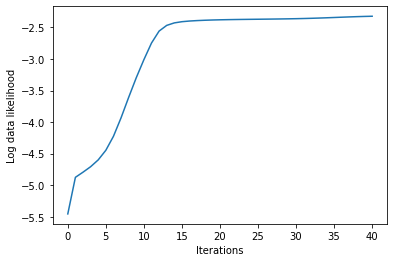

In [10]:
plt.plot(log_likelihood)
plt.ylabel('Log data likelihood')
plt.xlabel('Iterations')

In [16]:
print(time.time()-st)

8051.939712047577


In [ ]:
model.predict(training_data).shape

In [ ]:
# class haplotypeHMM(object):
#     '''
#     hidden_states -> mosaic state (X,Y), indicating states of diploids from haplotypes X and Y
#     transition -> transition prob for mosaic state
#     emission -> prob of genotype condition on mosaic state
#     inital -> prob initial mosaic state
    
#     '''
#     def __init__(self, genotypes, diplotypes, possible_haplotypes,seed=42,pseudocount=1e-100):
#         self.genotypes = list(set(genotypes))
#         self.diplotypes = list(set(hidden_states))
#         self.haplotypes = possible_haplotypes
#         self.seed = seed
#         self.pseudocount = pseudocount
#         self.transitions,self.emissions,self.initial = self.initialize_HMM_parameters_randomly(self.genotypes, self.diplotypes, self.seed)
    
#     def emit_prob(self, this_state, haplotype):
#         return self.emissions[this_state][haplotype]
    
#     def transition_prob(self, this_state, next_state):
#         return self.transitions[this_state][next_state]
    
#     def init_prob(self, this_state):
#         return self.initial[this_state]

#     def get_diplotypes(self):
#         for state in self.diplotypes:
#             yield state
#     def get_genotypes(self):
#         for genotype in self.genotypes:
#             yield genotype
#     def initialize_HMM_parameters_randomly(self, alphabet, states,seed):
        
#         transitions = {}
#         emissions = {}
#         initial = {}
#         np.random.seed(seed=seed)
#         initial_rand = np.random.dirichlet(np.ones(len(self.diplotypes)))
#         for i, state in enumerate(self.get_diplotypes()):
#             transitions[state] = {}
#             emissions[state] = {}
#             initial[state] = initial_rand[i]
#             emissions_rand = np.random.dirichlet(np.ones(len(self.genotypes)))
#             transitions_rand = np.random.dirichlet(np.ones(len(self.diplotypes)))
#             for j,geno in enumerate(self.get_genotypes()):
#                 emissions[state][geno] = emissions_rand[j]
#             for j, next_state in enumerate(self.get_diplotypes()):
#                 transitions[state][next_state] = transitions_rand[j]
                
#         return transitions,emissions,initial
#     def log_sum_exp(self,x):
#         x_arr = np.array(x)
#         x_log_arr = np.log(x_arr)
#         x_log_max = x_log_arr.max()
#         return x_log_max + np.log(np.sum(np.e**(x_log_arr-x_log_max)))
#     def sum_normalize(self,x):
#         return np.exp(np.log(np.array(x))-self.log_sum_exp(x))
#     def calculate_s_value(self, seq_pos, previous_vars,single_pos_genotype):
#         """Calculate the next scaling variable for a sequence position (PRIVATE).
#         This utilizes the approach of choosing s values such that the
#         sum of all of the scaled f values is equal to 1.
#         Arguments:
#          - seq_pos -- The current position we are at in the sequence.
#          - previous_vars -- All of the forward or backward variables
#            calculated so far.
#         Returns:
#          - The calculated scaling variable for the sequence item.
#         """
#         # all of the different letters the state can have
#         state_letters = self.get_diplotypes()

#         # loop over all of the possible states
#         s_value = 0
#         for main_state in state_letters:
#             emission = self.emit_prob(main_state,single_pos_genotype)

#             # now sum over all of the previous vars and transitions
#             trans_and_var_sum = 0
#             for second_state in state_letters:
#                 # the value of the previous f or b value
#                 var_value = previous_vars[seq_pos - 1][second_state]

#                 # the transition probability
#                 trans_value = self.transition_prob(main_state,second_state)

#                 trans_and_var_sum += var_value * trans_value

#             s_value += emission * trans_and_var_sum

#         return s_value
#     def forward(self, genotype):
#         left_list = []
#         left = {}
#         for state in self.get_diplotypes():
#             left[state] = self.init_prob(state) * self.emit_prob(state, genotype[0])
#         left_list.append(left)
        
#         for i in range(1, len(genotype)):
#             s_value = self.calculate_s_value(i,left_list,genotype[i])
#             left = {}
#             for next_state in self.get_diplotypes(): 
#                 left[next_state] = 0
#                 for this_state in self.get_diplotypes():
#                     left[next_state] += left_list[i-1][this_state] * self.transition_prob(this_state, next_state) 
#                 left[next_state] =  self.emit_prob(next_state, genotype[i]) * left[next_state]
#             for next_state in self.get_diplotypes():
#                 left[next_state] /= s_value
#             left_list.append(left)
#         # rescale left
# #         print('LEFT')
# #         print(left_list)
# #         print(scale_list)
# #         for i in range(len(left_list)):
# #             for state in self.get_diplotypes():
# #                 left_list[i][state] *= np.sum(scale_list[:i+1])
#         posterior = 0
#         for state in self.get_diplotypes():
#             posterior += left_list[-1][state]

#         return posterior, left_list


#     def backward(self, genotype):
# #         scale_list = [1]
#         right_list = [] 
#         right = {}
#         for state in self.get_diplotypes():
#             right[state] = 1
#         right_list.append(right)

#         for i in range(len(genotype)-2, -1, -1):
#             s_value = self.calculate_s_value(len(genotype)-1-i,right_list[::-1],genotype[i])

#             right = {} 
# #             scale = 0 
#             for state in self.get_diplotypes():
#                 right[state] = 0
#                 for next_state in self.get_diplotypes():
#                     right[state] += right_list[0][next_state] * self.transition_prob(state, next_state) * self.emit_prob(next_state, genotype[i])
# #                     scale += right[state]
# #             for state in self.get_diplotypes():
# #                 right[state] /= (scale_list[i+1]-scale_list[i])
# #             scale_list.insert(0,scale)
#             right_list.insert(0,right)
        
#         # rescale left
# #         print('RIGHT')
# #         print(right_list)
# #         print(scale_list)
# #         scaled_right_list = right_list.copy()
# #         for i in range(len(right_list)-1,-1,-1):
# #             for state in self.get_diplotypes():
# #                 right_list[i][state] *= np.sum(scale_list[i:])
        
#         posterior = 0
#         for state in self.get_diplotypes():
#             posterior += right_list[0][state] * self.init_prob(state) * self.emit_prob(state, genotype[0])

#         return posterior, right_list
#     def check_convergence(self,all_iters_total_likelihood,eps):
#         if np.linalg.norm(np.array(all_iters_total_likelihood[-1]) - np.array(all_iters_total_likelihood[-2])) < eps:
#             return True
#         else:
#             return False
#     def fit(self, genotypes, max_it,eps=1e-10):
#         pseudocount = self.pseudocount
#         # Train by Baum-Weltch
#         # Inititalization
#         all_iters_KL_divergence = []
#         transitions,emissions,initial = self.initialize_HMM_parameters_randomly(self.genotypes, self.diplotypes, self.seed)
#         for it in range(max_it):
#             print(f'------------------Iter:{it}------------------')
#              # Expectation
#             sum_Px = 0
#             # get the sum over Px first
#             for j in range(len(genotypes)):
#                 genotype = genotypes[j]
#                 # forward and backward
#                 f_Px, _ = self.forward(genotype)
#     #             r_Px, r_matrix = self.backward(genotype)
#                 sum_Px += 1/f_Px
# #             if it >= 1 and self.check_convergence(all_iters_total_likelihood,eps):
# #                 print(all_iters_total_likelihood)
# #                 break
#             for m in range(len(genotypes)):
#                 genotype = genotypes[m]
#                 # forward and backward
#                 f_Px, f_matrix = self.forward(genotype)
#                 r_Px, r_matrix = self.backward(genotype)
#                 for k in self.get_diplotypes():
#                     # Update transition matrix A
#                     for l in self.get_diplotypes():
#                         A = 0
#                         for i in range(len(genotype)-1):
#                             A += f_matrix[i][k] * self.transition_prob(k,l) *  self.emit_prob(l, genotype[i+1]) * r_matrix[i+1][l]
#                         transitions[k][l] = pseudocount + sum_Px * A

#                     # Update emission matrix E
#                     for j, sigma in enumerate(self.get_genotypes()):
#                         E = 0
#                         for i in range(len(genotype)):
#                             if genotype[i] == sigma:
#                                 E += f_matrix[i][k] * r_matrix[i][k]

#                         emissions[k][sigma] = pseudocount + sum_Px * E

#                     # Update initial state matrix B
#                     initial[k] = sum_Px * f_matrix[0][k] * r_matrix[0][k] 
#              # Maximization
#             for k in self.get_diplotypes():
#                 sum_A = 0
#                 for l in self.get_diplotypes():
#                     sum_A += transitions[k][l]
#                 for l in self.get_diplotypes():
#                     transitions[k][l] = transitions[k][l]/sum_A


#                 sum_E = 0
#                 for j, sigma in enumerate(self.get_genotypes()):
#                     sum_E += emissions[k][sigma]
#                 for j, sigma in enumerate(self.get_genotypes()):
#                     emissions[k][sigma] = emissions[k][sigma]/sum_E
# #             print('Param')
# #             print(transitions[k])
# #             print(emissions[k])
#             sum_B = 0
#             for k in self.get_diplotypes():
#                 sum_B += initial[k]
#             for k in self.get_diplotypes():
#                 initial[k] = initial[k]/sum_B
# #             # Maximization
            
# #             for k in self.get_diplotypes():
# #                 all_a = []
# #                 for l in self.get_diplotypes():
# #                     all_a.append(transitions[k][l])
# #                 all_normalized_a = self.sum_normalize(all_a)
# #                 for l_index,l in enumerate(self.get_diplotypes()):
# #                     transitions[k][l] = all_normalized_a[l_index]
                
# #                 all_e = []
# #                 for j, sigma in enumerate(self.get_genotypes()):
# #                     all_e.append(emissions[k][sigma])
                
# #                 all_normalized_e = self.sum_normalize(all_e)
# #                 for sigma_index, sigma in enumerate(self.get_genotypes()):
# #                     emissions[k][sigma] = all_normalized_e[sigma_index]

# #             all_b = []
# #             for k in self.get_diplotypes():
# #                 all_b.append(initial[k])
# #             all_normalized_b = self.sum_normalize(all_b)
            
# #             for k_index,k in enumerate(self.get_diplotypes()):
# #                 initial[k] = all_normalized_b[k_index]
# #             if it >= 1 and self.check_convergence(transitions,eps):
# #                 print(all_iters_total_likelihood)
# #                 break
#             self.transitions = transitions
#             self.emissions = emissions
#             self.initial = initial
#     def predict(self, genotype):
#         # Predict by Viterbi
#         previous_col_probs = {} 
#         traceback = []
#         for state in self.get_diplotypes():
#             previous_col_probs[state] = np.log(self.init_prob(state)) + np.log(self.emit_prob(state, genotype[0]))

#         for t in range(1, len(genotype)): 
#             previous_col_probs_next = {}
#             traceback_next = {}

#             for next_state in self.get_diplotypes():  
#                 k = {}
#                 for this_state in self.get_diplotypes():
#                     k[this_state] = previous_col_probs[this_state] + np.log(self.transition_prob(this_state, next_state)) 
#                 max_k = -np.inf
#                 argmax_k = None
#                 for state,val in k.items():
#                     if val > max_k:
#                         argmax_k = state
#                         max_k = val
#                 previous_col_probs_next[next_state] =  np.log(self.emit_prob(next_state, genotype[t])) + k[argmax_k]
#                 traceback_next[next_state] = argmax_k

#             previous_col_probs = previous_col_probs_next
#             traceback.append(traceback_next)

#         max_final_state = None
#         max_final_prob = -np.inf
#         for state,prob in previous_col_probs.items():
#             if prob > max_final_prob:
#                 max_final_prob = prob
#                 max_final_state = state

#         result = [max_final_state]
#         for t in range(len(genotype)-2,-1,-1):
#             result.append(traceback[t][max_final_state])
#             max_final_state = traceback[t][max_final_state]

#         return result[::-1]


In [362]:
# class haplotypeHMM_fast(object):
#     '''
#     hidden_states -> mosaic state (X,Y), indicating states of diploids from haplotypes X and Y
#     transition -> transition prob for mosaic state
#     emission -> prob of genotype condition on mosaic state
#     inital -> prob initial mosaic state
    
#     '''
#     def __init__(self, alphabet, hidden_states, possible_haplotypes, seed=None):
#         self._alphabet = alphabet
#         self._hidden_states = hidden_states
#         self._haplotypes = possible_haplotypes
#         self._seed = seed
#         self._initialize_theta()
#         self._transitions, self._emissions, self._initial = self._initialize_HMM(self._seed)
# #         if(self._transitions == None):
# #             self._initialize_random(self._alphabet, self._hidden_states, self._seed)
    
#     def _emit(self, cur_state, symbol):
#         return self._emissions[cur_state][symbol]
    
#     def _transition(self, cur_state, next_state):
#         return self._transitions[cur_state][next_state]
    
#     def _init(self, cur_state):
#         return self._initial[cur_state]

#     def _states(self):
#         for k in self._hidden_states:
#             yield k
#     def _emissions_by_theta(self,theta,state,prev_state):
#         H = len(self._haplotypes)
#         state_X,state_Y = state
#         prev_state_X,prev_state_Y = prev_state
#         if (state_X != prev_state_X) and (state_Y != prev_state_Y):
#             return theta**2/H**2
#         elif (state_X != prev_state_X) or (state_Y != prev_state_Y):
#             return (1-theta) * theta/H + theta**2/(H**2)
#         else:
#             return (1-theta) ** 2+ 2*(1-theta)*theta/H + theta**2/(H**2)
#     def _initialize_theta(self,):
#         self._theta = np.ones(len(self._hidden_states))//100
#     def _initialize_HMM(self,seed):
#         transitions = {}
#         emissions = {}
#         initial = {}
#         # initailize the inital prob by dirichlet distribution
#         np.random.seed(seed=seed)
#         initial_rand = np.random.dirichlet(np.ones(len(self._hidden_states)))
#         for i, state in enumerate(self._states()):
#             emissions[state] = {}
#             transitions[state] = {}
#             initial[state] = initial_rand
#             E_rand = np.random.dirichlet(np.ones(len(self._alphabet)))
#             for j, sigma in enumerate(self._get_alphabet()):
#                 emissions[state][sigma] = E_rand[j]
#             for j, next_state in enumerate(self._states()):
#                 transitions[state][next_state] = self._emissions_by_theta(self._theta[j],next_state,state)
#         return transitions,emissions,initial
# #     def _initialize_random(self, alphabet, states, seed):
# #         alphabet = list(set(alphabet))
# #         alphabet.sort()
# #         states = list(set(states))
# #         states.sort()
# #         self._alphabet = alphabet
# #         self._hidden_states = states

# #         #Initialize empty matrices A and E with pseudocounts
# #         A = {}
# #         E = {}
# #         I = {}
# #         np.random.seed(seed=seed)
# #         I_rand = np.random.dirichlet(np.ones(len(self._hidden_states)))
# #         for i, state in enumerate(self._states()):
# #             E[state] = {}
# #             A[state] = {}
# #             I[state] = I_rand[i]
# #             E_rand = np.random.dirichlet(np.ones(len(self._alphabet)))
# #             A_rand = np.random.dirichlet(np.ones(len(self._hidden_states)))
# #             for j, sigma in enumerate(self._get_alphabet()):
# #                 E[state][sigma] = E_rand[j]
# #             for j, next_state in enumerate(self._states()):
# #                 A[state][next_state] = A_rand[j]
                
# #         self._transitions = A
# #         self._emissions = E
# #         self._initial = I
# #         return
        
#     def _get_alphabet(self):
#         for sigma in self._alphabet:
#             yield sigma

#     def _Ca(self,hap_a,previous_left_chain,previous_geno):
#         Ca = 0
#         for hap_b in self._haplotypes:
#             state = (hap_a,hap_b)
#             Ca += previous_left_chain[state] * self._emit(state,previous_geno)
#         return Ca
#     def _C(self,previous_left_chain,previous_geno):
#         C = 0
#         for hap_a in self._haplotypes:
#             C += self._Ca(hap_a,previous_left_chain,previous_geno)
#         return C
#     def forward(self, sequence):
#         H = len(self._haplotypes)
#         # calculate left chain prob
#         left_list = [] 
#         left = {}
#         for state in self._states():
#             left[state] = 1
#         left_list.append(left)

#         for j in range(1, len(sequence)):  # For each position in the sequence
#             left = {}
#             for state in self._states(): # For each state
#                 (x,y) = state
#                 # refer to MACH paper
#                 left[state] = left_list[j-1][state] * self._emit(state,sequence[j-1]) * (1-self._theta[j]) ** 2 + \
#                 self._Ca(x,left_list[j-1],sequence[j-1]) * (1-self._theta[j]) * self._theta[j] / H + \
#                 self._Ca(y,left_list[j-1],sequence[j-1]) * (1-self._theta[j]) * self._theta[j] / H + \
#                 self._C(left_list[j-1],sequence[j-1]) * self._theta[j]**2 / H**2

#             left_list.append(left)
#         Px = 0
#         for state in self._states():
#             Px += left_list[-1][state]

#         return Px, left_list
#     def backward(self, sequence):
#         H = len(self._haplotypes)
#         # calculate right chain prob
#         right_list = [] 
#         right = {}
#         for state in self._states():
#             right[state] = 1
#         right_list.append(right)

#         for j in range(len(sequence)-2,-1,-1):  # For each position in the sequence
#             right = {}
#             for state in self._states(): # For each state
#                 (x,y) = state
#                 # refer to MACH paper
#                 right[state] = right_list[0][state] * self._emit(state,sequence[j+1]) * (1-self._theta[j]) ** 2 + \
#                 self._Ca(x,right_list[0],sequence[j+1]) * (1-self._theta[j]) * self._theta[j] / H + \
#                 self._Ca(y,right_list[0],sequence[j+1]) * (1-self._theta[j]) * self._theta[j] / H + \
#                 self._C(right_list[0],sequence[j+1]) * self._theta[j]**2 / H**2

#             right_list.insert(0,right)
#         Px = 0
#         for state in self._states():
#             Px += right_list[0][state] * self._init(state) * self._emit(state, sequence[0])

#         return Px, right_list
    
#     def baum_welch(self, sequences, pseudocount=1e-100):
#         """ The baum-welch algorithm for unsupervised HMM parameter learning

#         Args:
#             sequence (list): a list of sequences containing valid emissions from the HMM
#             pseudocount (float): small pseudocount value (default: 1e-100)

#         Returns:
#             None but updates the current HMM model parameters:
#              self._transitions, self._emissions, self._initial
        
#         """   
#         # Inititalization
#         transition,emissions,initial = self._initialize_HMM(self._seed)

#         # set the max iteration to 1 here to print the first iteration
#         max_it = 1
#         for it in range(max_it):
#              # Expectation
#             sum_Px = 0
#             # get the sum over Px first
#             for j in range(len(sequences)):
#                 sequence = sequences[j]
#                 # forward and backward
#                 f_Px, _ = self.forward(sequence)
#     #             r_Px, r_matrix = self.backward(sequence)
#                 sum_Px += 1/f_Px
#             for j in range(len(sequences)):
#                 sequence = sequences[j]
#                 # forward and backward
#                 f_Px, f_matrix = self.forward(sequence)
#                 r_Px, r_matrix = self.backward(sequence)
#                 for k in self._states():
#                     # Update transition matrix A
#                     for l in self._states():
#                         A = 0
#                         for i in range(len(sequence)-1):
#                             A += f_matrix[i][k] * self._transition(k,l) *  self._emit(l, sequence[i+1]) * r_matrix[i+1][l]
#                         transition[k][l] = sum_Px * A

#                     # Update emission matrix E
#                     for j, sigma in enumerate(self._get_alphabet()):
#                         E = 0
#                         for i in range(len(sequence)):
#                             if sequence[i] == sigma:
#                                 E += f_matrix[i][k] * r_matrix[i][k]

#                         emissions[k][sigma] = sum_Px * E

#                     # Update initial state matrix B
#                     initial[k] = sum_Px * f_matrix[0][k] * r_matrix[0][k]

#             # Maximization
#             for k in self._states():
#                 sum_A = 0 
#                 for l in self._states():
#                     sum_A += transition[k][l]
#                 for l in self._states():
#                     transition[k][l] = transition[k][l]/sum_A


#                 sum_E = 0
#                 for j, sigma in enumerate(self._get_alphabet()):
#                     sum_E += emissions[k][sigma]
#                 for j, sigma in enumerate(self._get_alphabet()):
#                     emissions[k][sigma] = emissions[k][sigma]/sum_E

#             sum_B = 0
#             for k in self._states():
#                 sum_B += initial[k]
#             for k in self._states():
#                 initial[k] = initial[k]/sum_B

#     #         self.__init__(self._get_alphabet, self._states, A=None, E=None, B=None, seed=None):
#             self._transitions = transition
#             self._emissions = emissions
#             self._initial = initial
# #             print(self)
#         pass
#     def viterbi(self, sequence):
#         """ The viterbi algorithm for decoding a string using a HMM

#         Args:
#             sequence (list): a list of valid emissions from the HMM

#         Returns:
#             result (list): optimal path through HMM given the model parameters
#                            using the Viterbi algorithm
        
#         Pseudocode for Viterbi:
#             Initialization (𝑖=0): 𝑣𝑘(𝑖)=𝑒𝑘(𝜎)𝑏𝑘.
#             Recursion (𝑖=1…𝑇): 𝑣𝑙(𝑖)=𝑒𝑙(𝑥𝑖) max𝑘(𝑣𝑘(𝑖−1)𝑎𝑘𝑙); 
#                                 ptr𝑖(𝑙)= argmax𝑘(𝑣𝑘(𝑖−1)𝑎𝑘𝑙).
#             Termination: 𝑃(𝑥,𝜋∗)= max𝑘(𝑣𝑘(𝑙)𝑎𝑘0); 
#                              𝜋∗𝑙= argmax𝑘(𝑣𝑘(𝑙)𝑎𝑘0).
#             Traceback: (𝑖=𝑇…1): 𝜋∗𝑖−1= ptr𝑖(𝜋∗𝑖).
#         """

#         # Initialization (𝑖=0): 𝑣𝑘(𝑖)=𝑒𝑘(𝜎)𝑏𝑘.
#         # Initialize trellis and traceback matrices
#         # trellis will hold the vi data as defined by Durbin et al.
#         # and trackback will hold back pointers
#         trellis = {} # This only needs to keep the previous column probabilities
#         traceback = [] # This will need to hold all of the traceback data so will be an array of dicts()
#         for state in self._states():
#             trellis[state] = np.log10(self._init(state)) + np.log10(self._emit(state, sequence[0])) # b * e(0) for all k
            
#         # Next we do the recursion step:
#         # Recursion (𝑖=1…𝑇): 𝑣𝑙(𝑖)=𝑒𝑙(𝑥𝑖) max𝑘(𝑣𝑘(𝑖−1)𝑎𝑘𝑙); 
#         #                 ptr𝑖(𝑙)= argmax𝑘(𝑣𝑘(𝑖−1)𝑎𝑘𝑙).
#         for t in range(1, len(sequence)):  # For each position in the sequence
#             trellis_next = {}
#             traceback_next = {}

#             for next_state in self._states():    # Calculate maxk and argmaxk
#                 k={}
#                 for cur_state in self._states():
#                     k[cur_state] = trellis[cur_state] + np.log10(self._transition(cur_state, next_state)) # k(t-1) * a
#                 argmaxk = max(k, key=k.get)
#                 trellis_next[next_state] =  np.log10(self._emit(next_state, sequence[t])) + k[argmaxk] # k * e(t)
#                 traceback_next[next_state] = argmaxk
                
#             #Overwrite trellis 
#             trellis = trellis_next
#             #Keep trackback pointer matrix
#             traceback.append(traceback_next)
            
#         # Termination: 𝑃(𝑥,𝜋∗)= max𝑘(𝑣𝑘(𝑙)𝑎𝑘0); 
#         #                  𝜋∗𝑙= argmax𝑘(𝑣𝑘(𝑙)𝑎𝑘0).
#         max_final_state = max(trellis, key=trellis.get)
#         max_final_prob = trellis[max_final_state]
                
#         # Traceback: (𝑖=𝑇…1): 𝜋∗𝑖−1= ptr𝑖(𝜋∗𝑖).
#         result = [max_final_state]
#         for t in reversed(range(len(sequence)-1)):
#             result.append(traceback[t][max_final_state])
#             max_final_state = traceback[t][max_final_state]

#         return result[::-1]
    

In [180]:
-np.inf

-inf

In [ ]:
import time
st = time.time()
hidden_states =  list(all_possible_dips)
alphabet = [0,1,2] # DNA Alphabet

model = haplotypeHMM(alphabet, hidden_states,range(len(all_possible_haps_index)),seed=70,pseudocount=1e-100)

model.fit(genos[:5,:10].T,10,eps=1e-6)
print(time.time()-st)

In [39]:
genos[:5,:10]

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 0, 1, 0, 1, 1, 2, 1, 1, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 0, 1, 0, 1, 1, 2, 1, 1, 2]])

In [38]:
baum_welch_scaling(genos[:5,:10].T,len(hidden_states),len(alphabet),len(genos[:5,:10].T))

ValueError: operands could not be broadcast together with shapes (37,) (37,5) 